# 1. General Code


   ## 1.1 Libraries


In [234]:
# Libraries for data manipulation and analysis
import numpy as np
import pandas as pd
from packages.common_functions import decompress_file, load_csv_into_dataframe, load_dataframe_to_csv

In [235]:
# Importing libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [236]:
# Importing libraries for machine learning
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OrdinalEncoder
import joblib
from packages.machine_learning_class import ModeloML

   ## 1.2 Data Visualization Parameters


In [237]:
# Configuration of initial parameters for the Matplotlib library
params = {
    'figure.figsize': (16, 10),  # Size of the figure (width, height)
    'figure.dpi': 80,  # Figure resolution in dots per inch
    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',  # Edge color of the figure
    'figure.frameon': True,  # Show or hide the frame of the figure
    'figure.constrained_layout.use': False,  # Enable constrained layout for figures
    'figure.constrained_layout.h_pad': 0.04167,  # Horizontal spacing in constrained layout
    'figure.constrained_layout.w_pad': 0.04167,  # Vertical spacing in constrained layout
    'axes.labelsize': 12,  # Size of the axis labels
    'axes.titlesize': 14,  # Size of the title
    'axes.labelweight': 'normal',  # Font weight of the labels
    'xtick.labelsize': 10,  # Size of the x-axis labels
    'ytick.labelsize': 10,  # Size of the y-axis labels
    'xtick.color': 'black',  # Color of the x-axis labels
    'ytick.color': 'black',  # Color of the y-axis labels
    'axes.spines.top': True,  # Show or hide top border
    'axes.spines.right': True,  # Show or hide right border
    'legend.frameon': True,  # Show or hide legend frame
    'grid.linestyle': '-',  # Style of grid lines
    'grid.linewidth': 0.8,  # Width of grid lines
    'grid.color': 'gray',  # Color of grid lines
    'legend.fontsize': 10,  # Font size of the legend
    'axes.titleweight': 'normal',  # Font weight of the title
    'axes.titlecolor': 'black',  # Color of the title
    'axes.titlelocation': 'center',  # Location of the title (left, center, right)
}

In [238]:
# Applying the initial parameters
plt.rcParams.update(params)

In [239]:
# Using the 'tableau-colorblind10' style
plt.style.use('tableau-colorblind10')

In [240]:
# Activating inline visualization of plots
%matplotlib inline

   ## 1.3 EDA Functions


In [241]:
# this is not need

   ## 1.4 Preprocessing Functions


### 1.4.1 Encoding DataFrame function

In [242]:
def label_encoder(dataframe, columns, encoding=False, decoding=False, le_dict=None):
    """
    Encodes or decodes labels in the specified columns of the DataFrame.

    Args:
        dataframe (pd.DataFrame): Original DataFrame.
        columns (list): List of column names to encode or decode.
        encoding (bool): If True, performs label encoding.
        decoding (bool): If True, performs label decoding.
        le_dict (dict): Dictionary to store LabelEncoder instances.

    Returns:
        pd.DataFrame: DataFrame with encoded or decoded columns.
        dict: Dictionary with LabelEncoder instances.
    """
    if le_dict is None:
        le_dict = {}

    if encoding:
        encoded_df = dataframe.copy()
        for col in columns:
            le = LabelEncoder()
            encoded_df[col] = le.fit_transform(encoded_df[col])
            le_dict[col] = le
        return encoded_df, le_dict

    elif decoding:
        decode_df = dataframe.copy()
        for col in columns:
            if col in le_dict:
                decode_df[col] = le_dict[col].inverse_transform(decode_df[col])
            else:
                raise ValueError(f"No LabelEncoder instance found for column {col}")
        return decode_df

    else:
        pass

### 1.4.2 Imputation null values function

#### 1.4.2.1 Imputation by dispersion measures

In [243]:
def impute_null_values_by_mode(df, column_to_impute, grouping_column):
    """
    Imputes null values in a column based on the mode of another column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the data.
    - column_to_impute (str): Name of the column to be imputed.
    - grouping_column (str): Name of the column used for grouping and mode calculation.
    """
    # Calculate the mode value of the column grouped by the grouping column
    mode_df = df.groupby(grouping_column)[column_to_impute].apply(lambda x: x.mode().iat[0] if not x.mode().empty else None).reset_index()

    # Create a dictionary to map values of the grouping column to their respective mode values
    mode_mapping = dict(zip(mode_df[grouping_column], mode_df[column_to_impute]))

    # Impute the specified column based on the mode mapping
    df[column_to_impute] = df.apply(lambda row: mode_mapping[row[grouping_column]] if pd.isnull(row[column_to_impute]) else row[column_to_impute], axis=1)
    
    return df

#### 1.4.2.2 Imputation by ml model

In [244]:
def impute_null_values_by_ml_model(codec_df, objetive_column, specific_null_value, ml_model_path):
    """
    This function imputes null values in a specific column based on a specific machine learning model.

    Params:
    - codec_df (pd.DataFrame): Data frame with encoded data.
    - objetive_column (str): Name of the column in which null values are imputed.
    - specific_null_value: Value that represents null values in the column.
    - ml_model_path (str): Path that contains the machine learning model previously trained.
    """

    # Load pre-trained ml model
    modelo_ml = joblib.load(ml_model_path)

    # Filter columns that contain null values
    missing_data = codec_df[codec_df[objetive_column] == specific_null_value]

    # Select features to predict without deleting rows with missing values
    X = codec_df.drop(objetive_column, axis=1).copy()

    # Filter prediction features based on rows with missing values
    caracteristicas_prediccion = X[X.index.isin(missing_data.index)]

    if not caracteristicas_prediccion.empty:
        # Predict null values
        predicts = modelo_ml.predict(caracteristicas_prediccion)

        # Fill missing values ​​with predictions in the original DataFrame
        codec_df.loc[codec_df[objetive_column] == specific_null_value, objetive_column] = predicts

    else:
        print(f"No hay muestras para predecir en la columna {objetive_column}.")


# 2. Data


   ## 2.1 Import CSV File


In [245]:
CLEAN_CENSUS_PATH = '../data/processed_csv/2014_census_clean.csv'

In [246]:
# Reading the clean census data into a pandas DataFrame
# In my analysis, I'm loading the data from the specified file path into a DataFrame
df = load_csv_into_dataframe(CLEAN_CENSUS_PATH)

CSV file successfully load in DataFrame.


In [247]:
# Sampling 7 random rows from the clean census DataFrame with a specified random state
# In my analysis, I'm randomly selecting 7 rows from the DataFrame using a fixed seed for reproducibility
sampled_data = df.sample(7, random_state=5)
sampled_data

,ID_SECTOR,AREA_2000,PROVINCIA,ZONA_PLANIFICACION,REGION_NATURAL,SEXO,EDAD,ULTIMO_NIVEL_EDUCATIVO,GRADO_CURSO,ANIOS_TRABAJO,MES,ANIO,CIUDAD
38902,90150098001,Urbano,Guayas,8,Costa,Hombre,38,Secundaria,2,0,1,2014,Guayaquil
8624,20153999004,Rural,Bolivar,5,Sierra,Mujer,49,Ninguno,0,0,2,2014,NaN
103618,230150060008,Urbano,Santo Domingo de los Tsachilas,4,Sierra,Mujer,65,Primaria,3,0,11,2013,NaN
89540,180168999017,Rural,Tungurahua,3,Sierra,Hombre,59,Alfabetización,1,30,1,2014,NaN
50383,100157001006,Urbano,Imbabura,1,Sierra,Mujer,4,NaN,0,0,9,2014,NaN
53559,110150024010,Urbano,Loja,7,Sierra,Mujer,2,NaN,0,0,5,2014,NaN
55787,110756999003,Rural,Loja,7,Sierra,Hombre,6,Educación básica,1,0,5,2014,NaN


In [248]:
# Extracting unique values from the 'PROVINCIA' column in the clean census DataFrame
# In my analysis, I'm retrieving the unique values present in the 'PROVINCIA' column
df['PROVINCIA'].unique()

array(['Azuay', 'Bolivar', 'Cañar', 'Carchi', 'Cotopaxi', 'Chimborazo',
       'El Oro', 'Esmeraldas', 'Guayas', 'Imbabura', 'Loja', 'Los Rios',
       'Manabi', 'Morona Santiago', 'Napo', 'Pastaza', 'Pichincha',
       'Tungurahua', 'Zamora Chinchipe', 'Galápagos', 'Sucumbios',
       'Orellana', 'Santo Domingo de los Tsachilas', 'Santa Elena'],
      dtype=object)

   ## 2.2 Exploratory Data Analysis


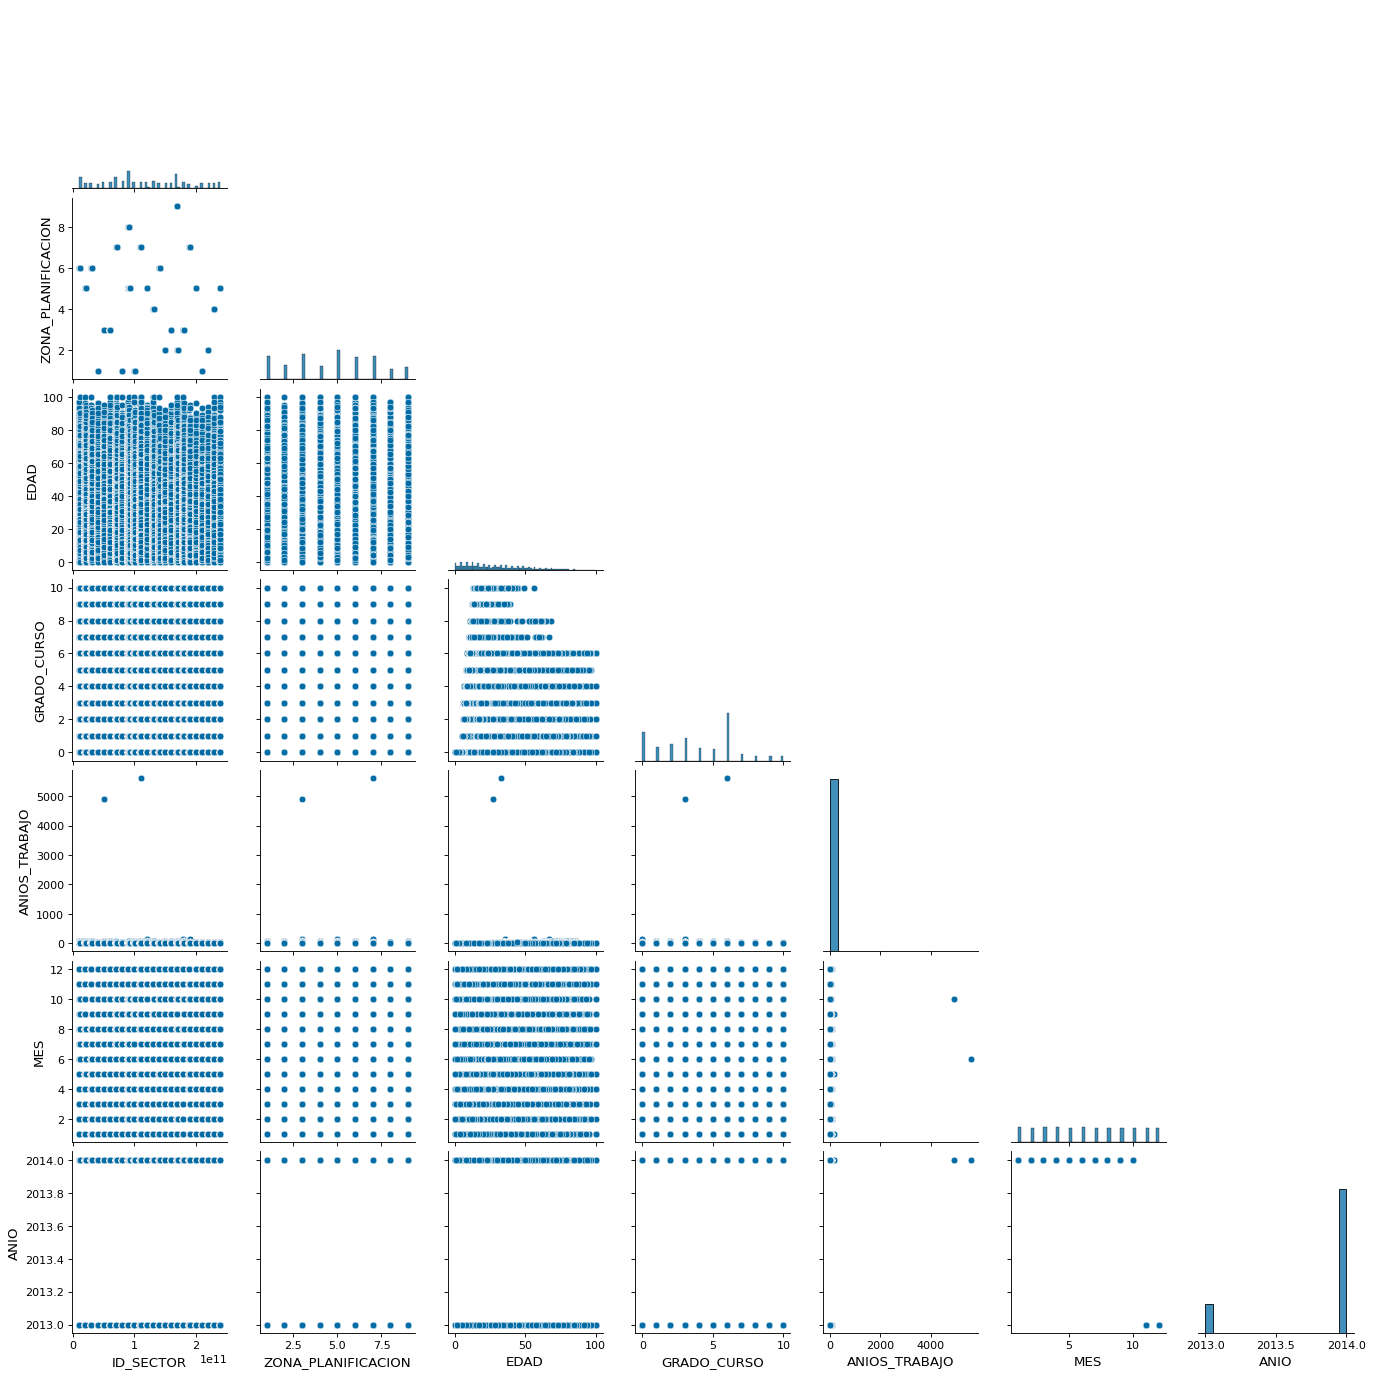

In [249]:
# Creating a pair plot for exploratory data analysis using Seaborn
# Assuming that the DataFrame 'df' contains relevant numerical columns

# Creating the pair plot with the mask
sns.pairplot(df, corner=True)

# Displaying the pair plot for a comprehensive view of variable interactions
plt.show()


In [250]:
# Calculating the age threshold based on the year 2023
# In my analysis, I'm determining the age threshold for individuals of 50 years or more in 2023
calculate_age = 50 - (2023 - 2014)

In [251]:
# Creating a new DataFrame with rows of individuals aged 50 or more in the year 2023 in the province of Pichincha
# In my analysis, I'm filtering the original DataFrame for individuals aged 50 or more in 2023 and residing in Pichincha
df_age_fifty_pichincha_quito = df.loc[(df['EDAD'] >= calculate_age) & (df['PROVINCIA'] == 'Pichincha') & (df['CIUDAD'] == 'Quito')]

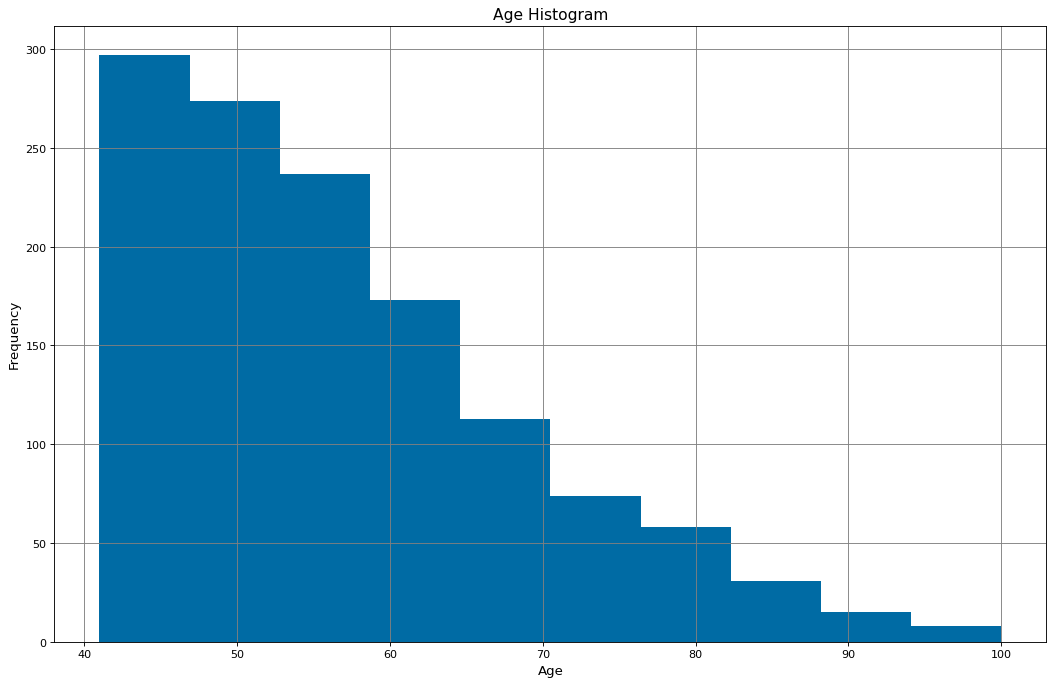

In [252]:
# Assuming 'df' is my DataFrame
# Creating a histogram for individuals aged 50 or more in the province of Pichincha
# In my analysis, I'm visualizing the age distribution for this specific group

df_age_fifty_pichincha_quito['EDAD'].hist()

# Adding labels to the plot for clarity
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Histogram')
plt.show()

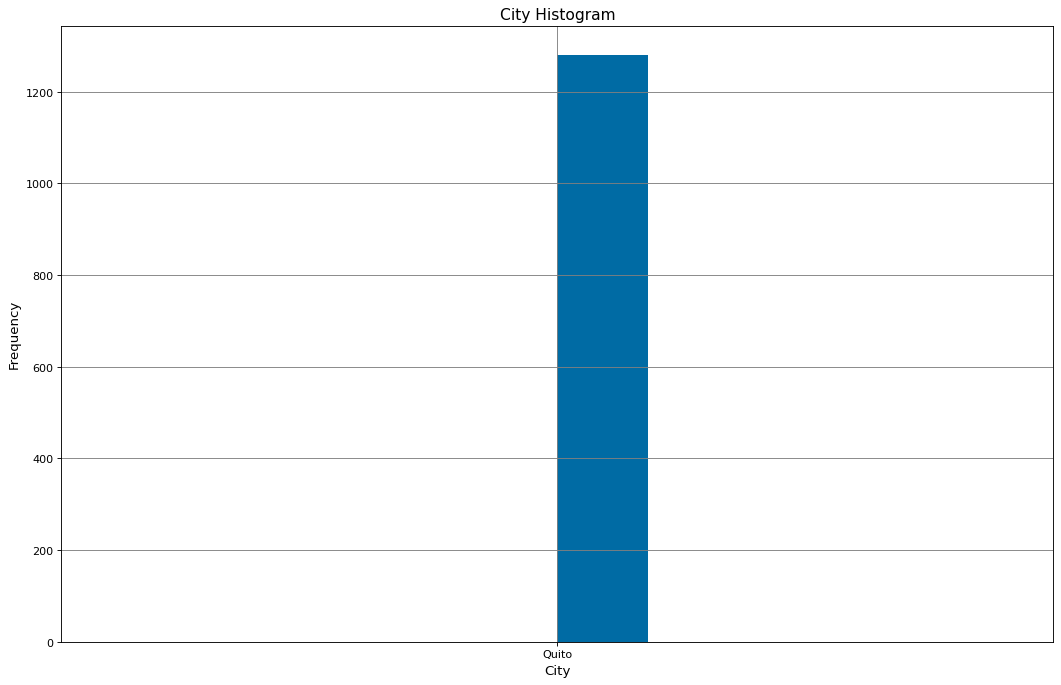

In [253]:
# Assuming 'df' is my DataFrame
# Creating a histogram for cities of individuals aged 50 or more in the province of Pichincha
# In my analysis, I'm visualizing the distribution of cities for this specific group

df_age_fifty_pichincha_quito['CIUDAD'].hist()

# Adding labels to the plot for clarity
plt.xlabel('City')
plt.ylabel('Frequency')
plt.title('City Histogram')
plt.show()

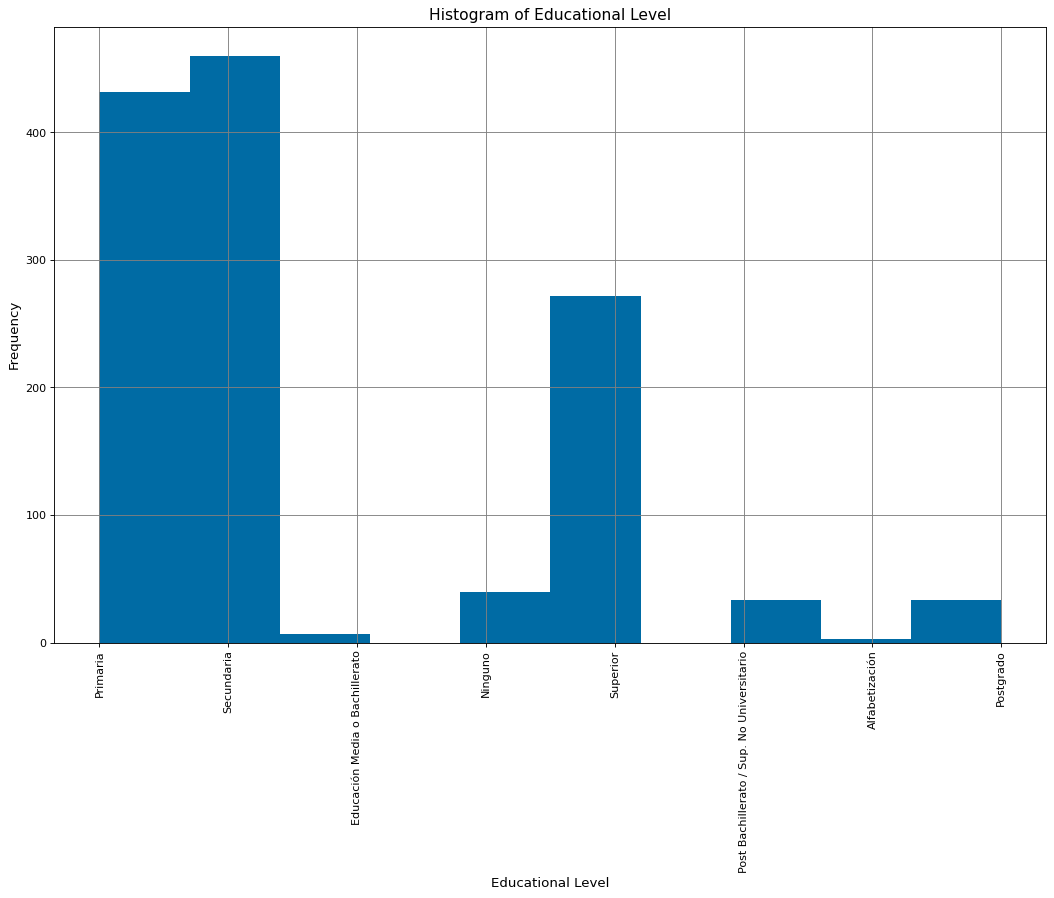

In [254]:
# Assuming 'df' is my DataFrame
# Creating a histogram for the level of higher education of individuals aged 50 or more in the province of Pichincha
# In my analysis, I'm visualizing the distribution of education levels for this specific group

df_age_fifty_pichincha_quito['ULTIMO_NIVEL_EDUCATIVO'].hist()

# Adding labels to the plot for clarity
plt.xlabel('Educational Level')
plt.ylabel('Frequency')
plt.title('Histogram of Educational Level')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.show()


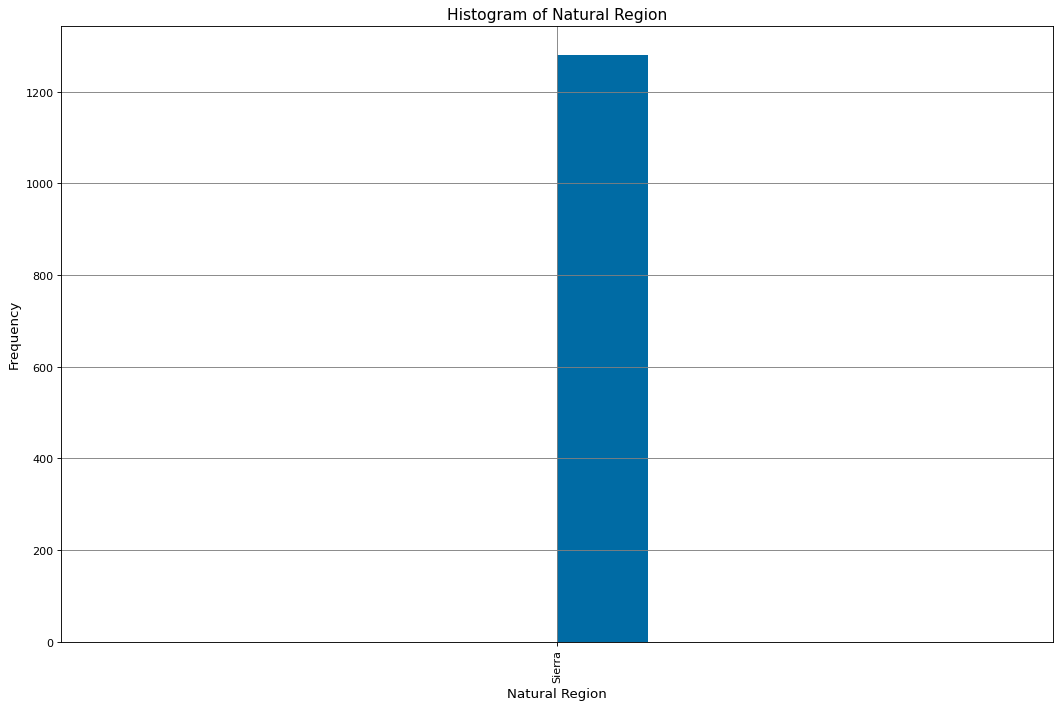

In [255]:
# Assuming 'df' is my DataFrame
# Creating a histogram for the natural region of individuals aged 50 or more in the province of Pichincha
# In my analysis, I'm visualizing the distribution of natural regions for this specific group

df_age_fifty_pichincha_quito['REGION_NATURAL'].hist()

# Adding labels to the plot for clarity
plt.xlabel('Natural Region')
plt.ylabel('Frequency')
plt.title('Histogram of Natural Region')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.show()

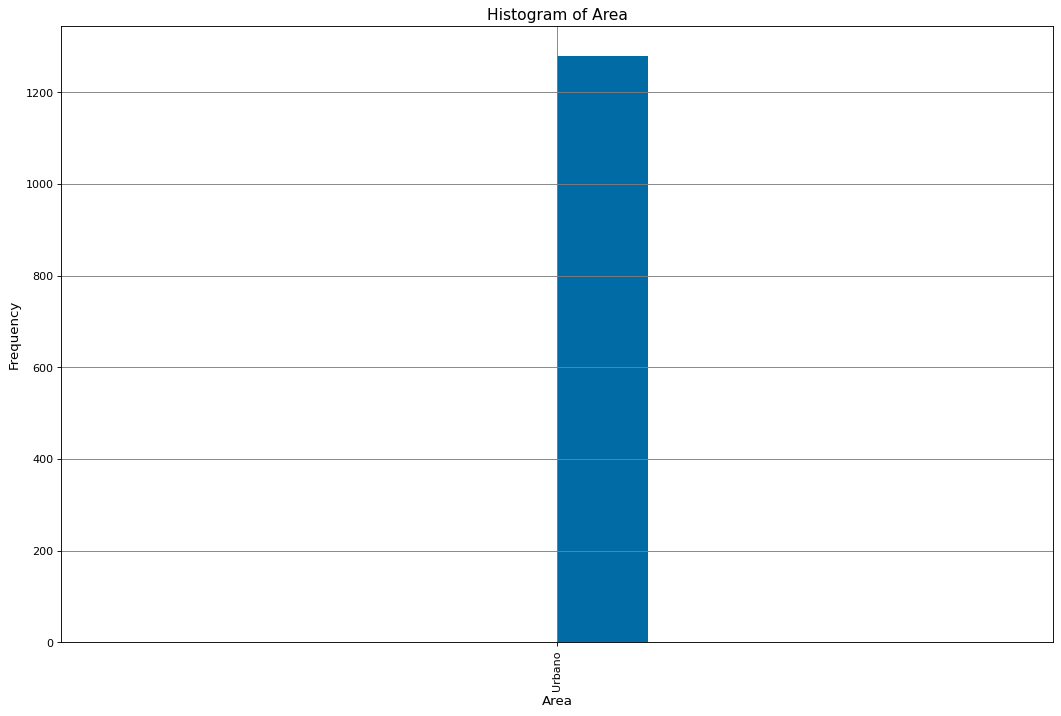

In [256]:
# Assuming 'df' is my DataFrame
# Creating a histogram for the AREA_2000 variable of individuals aged 50 or more in the province of Pichincha
# In my analysis, I'm visualizing the distribution of the AREA_2000 variable for this specific group

df_age_fifty_pichincha_quito['AREA_2000'].hist()

# Adding labels to the plot for clarity
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.title('Histogram of Area')
plt.xticks(rotation=90)  # Rotating x-axis labels for better readability
plt.show()


### 2.2.1 Text Analysis


In [257]:
#there is not need

### 2.2.2 Number of Variables per Data Types


In [258]:
# Checking the data types of columns in the DataFrame 'df'
# In my analysis, I'm inspecting the data types of each column

print(df_age_fifty_pichincha_quito.dtypes)


ID_SECTOR                  int64
AREA_2000                 object
PROVINCIA                 object
ZONA_PLANIFICACION         int64
REGION_NATURAL            object
SEXO                      object
EDAD                       int64
ULTIMO_NIVEL_EDUCATIVO    object
GRADO_CURSO                int64
ANIOS_TRABAJO              int64
MES                        int64
ANIO                       int64
CIUDAD                    object
dtype: object


### 2.2.3 Proportion Between Categorical Variables

In [291]:
#there is not need

### 2.2.4 Basic Statistics

In [292]:
# Generating descriptive statistics for different types of columns in the DataFrame 'df'.
df.describe(include='all')

,ID_SECTOR,AREA_2000,PROVINCIA,ZONA_PLANIFICACION,REGION_NATURAL,SEXO,EDAD,ULTIMO_NIVEL_EDUCATIVO,GRADO_CURSO,ANIOS_TRABAJO,MES,ANIO,CIUDAD
count,1.096940e+05,109694,109694,109694.000000,109694,109694,109694.000000,98221,109694.000000,109694.000000,109694.00000,109694.000000,16354
unique,NaN,2,24,NaN,4,2,NaN,10,NaN,NaN,NaN,NaN,4
top,NaN,Urbano,Guayas,NaN,Sierra,Mujer,NaN,Educación básica,NaN,NaN,NaN,NaN,Guayaquil
freq,NaN,55059,11334,NaN,52326,55397,NaN,30298,NaN,NaN,NaN,NaN,5307
mean,1.172315e+11,NaN,NaN,4.701433,NaN,NaN,28.589968,NaN,3.879337,1.154831,6.46977,2013.835178,NaN
std,6.600366e+10,NaN,NaN,2.406265,NaN,NaN,21.344113,NaN,2.703888,23.132177,3.44737,0.371022,NaN
min,1.015000e+10,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,1.00000,2013.000000,NaN
25%,7.015003e+10,NaN,NaN,3.000000,NaN,NaN,11.000000,NaN,2.000000,0.000000,3.00000,2014.000000,NaN
50%,1.102510e+11,NaN,NaN,5.000000,NaN,NaN,24.000000,NaN,4.000000,0.000000,6.00000,2014.000000,NaN
75%,1.701640e+11,NaN,NaN,7.000000,NaN,NaN,43.000000,NaN,6.000000,0.000000,9.00000,2014.000000,NaN


 ### 2.2.5 Linear Correlations

#### 2.2.5.1 Correlation matrix

In [293]:
# Calculating the correlation matrix of the scaled data.
matriz_correlacion_df = scaled_df.corr()

In [294]:
# Creating an upper triangular mask to hide the redundant half of the matrix.
mask = np.triu(np.ones_like(matriz_correlacion_df, dtype=bool))

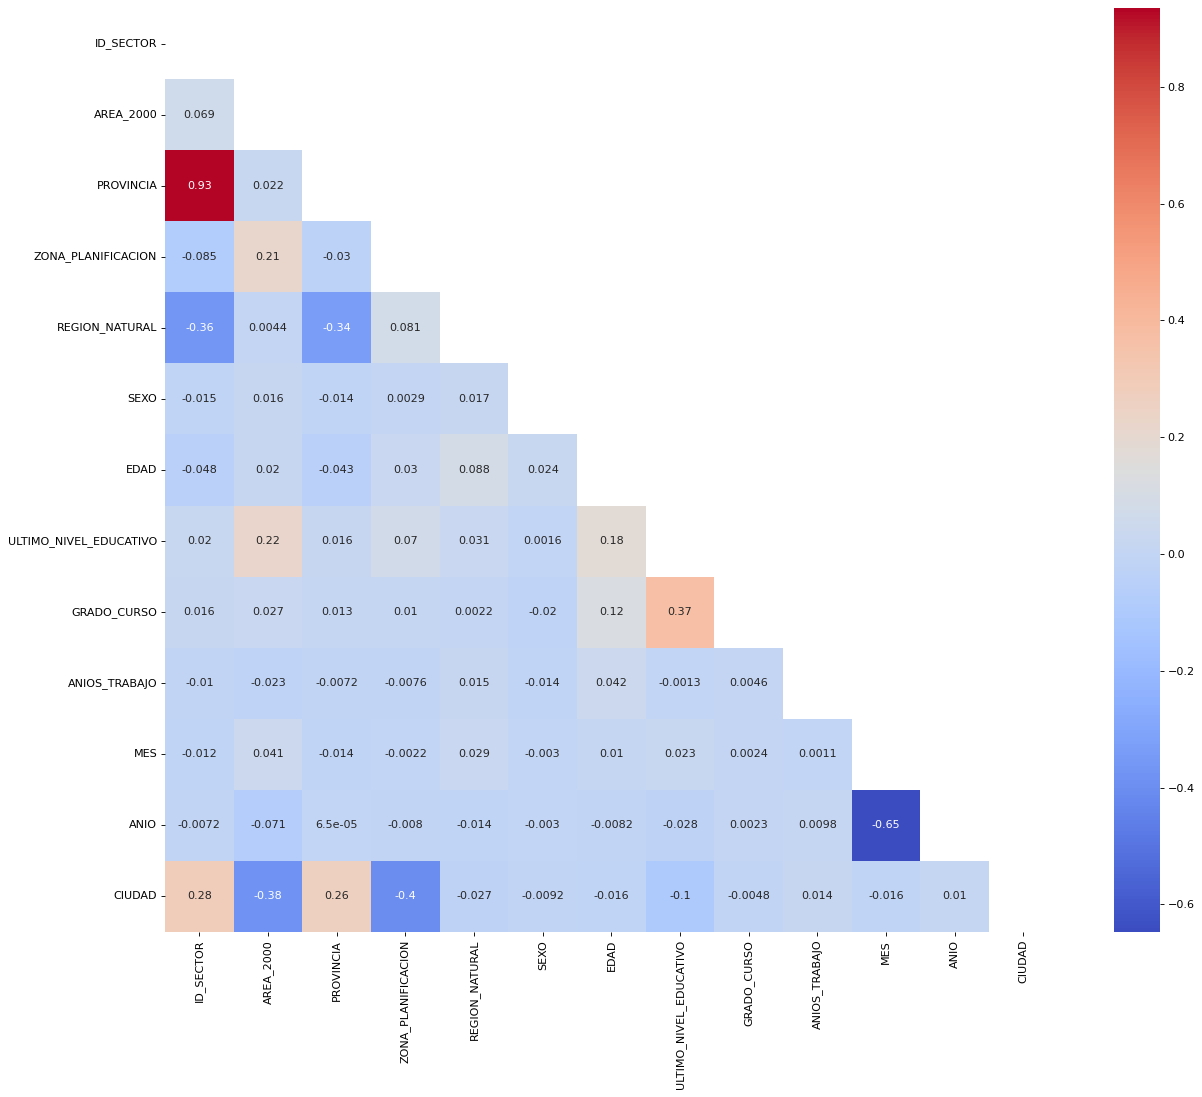

In [295]:
# Creating a heatmap to visualize the correlation matrix.
plt.figure(figsize=(18, 15))
sns.heatmap(matriz_correlacion_df, mask=mask, annot=True, cmap='coolwarm')

# Displaying the heatmap.
plt.show()

#### 2.2.5.2 Pairs of columns greater than 70% of correlation

In [296]:
# Define the correlation threshold (35% or -35% in absolute value).
# In your analysis, the correlation threshold is set at 0.70.
threshold = 0.70

# Find correlations that meet the threshold and store them in a list of tuples.
unique_tuples_result = [
    (col1, col2, value)
    for col1 in matriz_correlacion_df.columns
    for col2, value in matriz_correlacion_df[col1].items()
    if (col1 < col2) and abs(value) >= threshold and not np.isnan(value)
]

In [297]:
# Create a list of labels for column pairs
pares_columnas = [f'{col1} - {col2}' for col1, col2, correlation in unique_tuples_result]

In [298]:
# Create a list of correlation values
correlation_values = [correlation for col1, col2, correlation in unique_tuples_result]

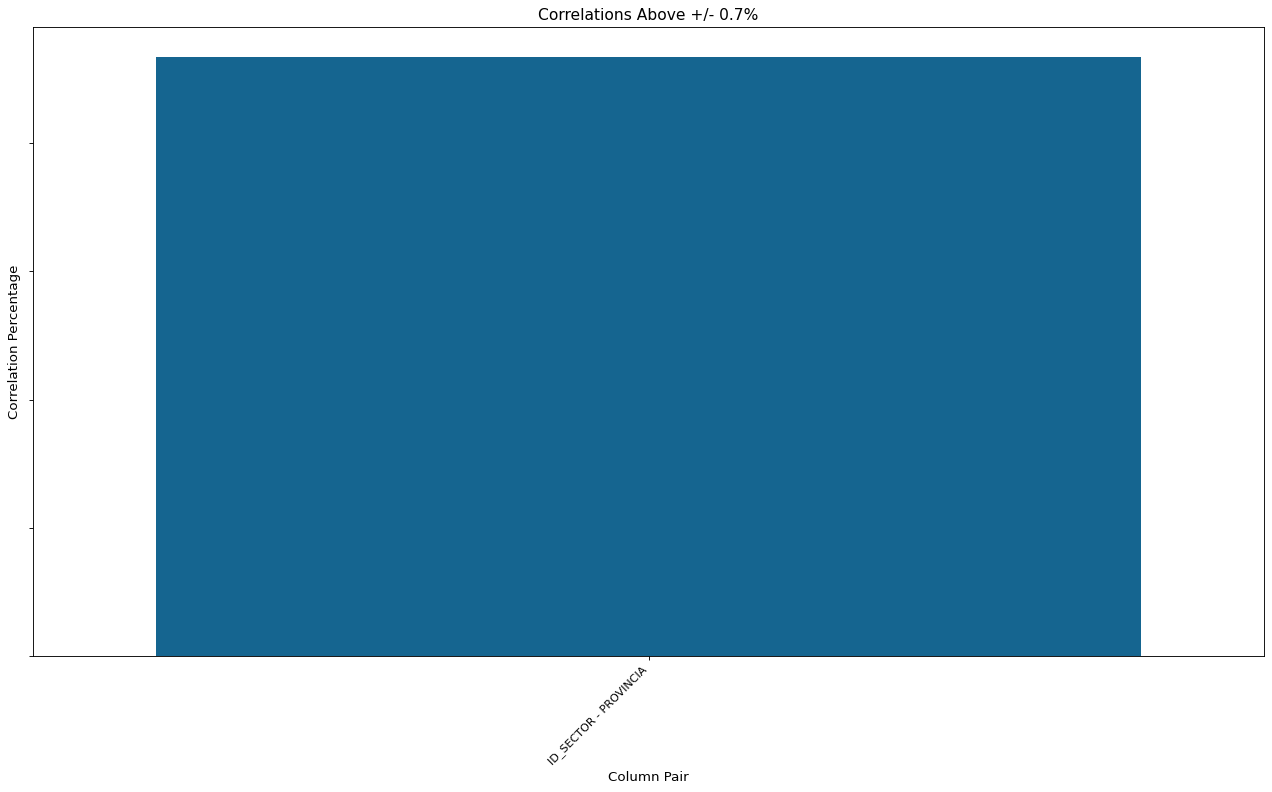

In [299]:
# Using Seaborn to create a bar plot with specified column pairs and correlation values
ax = sns.barplot(x=pares_columnas, y=correlation_values)

# Configuring the plot title
plt.title(f'Correlations Above +/- {threshold}%')
plt.xlabel('Column Pair')
plt.ylabel('Correlation Percentage')

# Adjusting the x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Removing y-axis labels for better visualization
ax.set_yticklabels([])

# Adjusting the layout for a cleaner presentation
plt.tight_layout()

# Displaying the bar plot
plt.show()


   ## 2.3 Preprocessing and Enrichment


### 2.3.1 Coding Columns

In [259]:
codec_df = df.copy()

In [260]:
# Encoding nominal categorical columns
# Selecting columns of type 'object' for encoding
nominal_columns = ['AREA_2000', 'PROVINCIA', 'CIUDAD', 'REGION_NATURAL', 'SEXO']

In [261]:
codec_df, le_dict = label_encoder(dataframe=codec_df, columns=nominal_columns, encoding=True)

In [262]:
# Create a dictionary with ordered values
educational_categories_ordered = {
    'Ninguno': 0,
    'Alfabetización': 1,
    'Educación inicial': 2,
    'Primaria': 3,
    'Educación básica': 4,
    'Educación Media o Bachillerato': 5,
    'Secundaria': 6,
    'Post Bachillerato / Sup. No Universitario': 7,
    'Superior': 8,
    'Postgrado': 9
}

In [263]:
# Apply encoding using the map method and assign a default value for NaN
codec_df['ULTIMO_NIVEL_EDUCATIVO'] = codec_df['ULTIMO_NIVEL_EDUCATIVO'].map(educational_categories_ordered).fillna(-1, downcast='int')

In [264]:
# Ensure that the column is of integer type
codec_df['ULTIMO_NIVEL_EDUCATIVO'] = codec_df['ULTIMO_NIVEL_EDUCATIVO'].astype(int)

### 2.3.2 Scaling Columns

In [265]:
# Instantiate MinMaxScaler for feature scaling.
scaler = MinMaxScaler()

In [266]:
# Copy the encoded data for preservation.
scaled_df = codec_df.copy()

# Apply scaler to normalize features using fit_transform.
scaled_df = scaler.fit_transform(scaled_df)

In [267]:
# Creating a DataFrame from the scaled data using pandas.
# In my analysis, I'm constructing a DataFrame to preserve the data structure and column names.

scaled_df = pd.DataFrame(scaled_df, columns=codec_df.columns)

In [268]:
# Displaying the scaled DataFrame 'scaled_df'
# In my analysis, I'm showing the content of the scaled data
print(scaled_df)


        ID_SECTOR  AREA_2000  PROVINCIA  ZONA_PLANIFICACION  REGION_NATURAL  \
0             0.0        1.0   0.000000               0.625        1.000000   
1             0.0        1.0   0.000000               0.625        1.000000   
2             0.0        1.0   0.000000               0.625        1.000000   
3             0.0        1.0   0.000000               0.625        1.000000   
4             0.0        1.0   0.000000               0.625        1.000000   
...           ...        ...        ...                 ...             ...   
109689        1.0        1.0   0.826087               0.500        0.333333   
109690        1.0        1.0   0.826087               0.500        0.333333   
109691        1.0        1.0   0.826087               0.500        0.333333   
109692        1.0        1.0   0.826087               0.500        0.333333   
109693        1.0        1.0   0.826087               0.500        0.333333   

        SEXO  EDAD  ULTIMO_NIVEL_EDUCATIVO  GRADO_C

### 2.3.3 Null Values


#### 2.3.3.1 Impute Null Values

<span style="color:red"> Execute on second iteration, later execute machine learning stage. </span>

In [269]:
# Create a copy of the original DataFrame for imputation
imputed_df = df.copy()

##### 2.3.3.1.1 Imputation by Dispersion Measures


'CIUDAD' Column


In [270]:
codec_df_ciudad = codec_df.copy()

In [271]:
col_to_input = 'CIUDAD'

In [272]:
# Decode values equivalent to before codec in column 'CIUDAD'
column_to_decode = [col_to_input]

codec_df_ciudad = label_encoder(dataframe=codec_df_ciudad, columns=column_to_decode, decoding=True, le_dict=le_dict)

In [273]:
# Null values pre imputation
total_nulls_pre_imputation = codec_df_ciudad[col_to_input].isnull().sum()

In [274]:
# Example usage for 'CIUDAD' column
codec_df_ciudad = impute_null_values_by_mode(codec_df_ciudad, col_to_input, 'PROVINCIA')

In [275]:
# Sum of null values post imputation in 'CIUDAD' column
total_nulls_post_imputation = codec_df_ciudad[col_to_input].isnull().sum()

In [276]:
print(
    f'''
    Quantity of null values in {col_to_input} column before imputation of null values: {total_nulls_pre_imputation}
    Quantity of null values in {col_to_input} column after imputation of null values: {total_nulls_post_imputation}
    '''
)


    Quantity of null values in CIUDAD column before imputation of null values: 93340
    Quantity of null values in CIUDAD column after imputation of null values: 73605
    


In [277]:
imputed_df[col_to_input] = codec_df_ciudad[col_to_input]

##### 2.3.3.1.2 Imputation by Machine Learning Models


"CIUDAD" Column


In [278]:
# in it case i do not use ml logistig regression becouse it is low acuracy percent

"ULTIMO_NIVEL_EDUCATIVO" Column


In [279]:
codec_df_ultimo_educativo = codec_df.copy()

In [280]:
# list with destination ml model path and destination decompressing folder path
model_paths = [
    ('..data/ml_best_model/ultimo_nivel_educativo_random_forest.pkl.zip', '../data/ml_best_model/')
]

In [281]:
# Iterate over each file and destination pair, calling the decompress_file function
for file_path, destination in model_paths:
    decompress_file(file_path, destination)

Error decompressing the file: [Errno 2] No such file or directory: '..data/ml_best_model/ultimo_nivel_educativo_random_forest.pkl.zip'


In [282]:
#Column to imputation values
col_to_input = 'ULTIMO_NIVEL_EDUCATIVO'

In [283]:
# path to ml model for imputation of null values
ML_MODEL_PATH_TO_ULTIMO_NIVEL_EDUCATIVO_IMPUTATION = '../data/ml_best_model/ultimo_nivel_educativo_random_forest.pkl'

In [284]:
# Check the sum of null values in the "ULTIMO_NIVEL_EDUCATIVO" column before imputation
total_nulls_pre_imputation = codec_df_ultimo_educativo[codec_df_ultimo_educativo[col_to_input] == -1].size

In [285]:
# Impute missing values in the "ULTIMO_NIVEL_EDUCATIVO" column
impute_null_values_by_ml_model(codec_df_ultimo_educativo, col_to_input, -1, ML_MODEL_PATH_TO_ULTIMO_NIVEL_EDUCATIVO_IMPUTATION)

In [286]:
# Map numeric values to specific educational categories
educational_categories_ordered = {
    0: 'Ninguno',
    1: 'Alfabetización',
    2: 'Educación inicial',
    3: 'Primaria',
    4: 'Educación básica',
    5: 'Educación Media o Bachillerato',
    6: 'Secundaria',
    7: 'Post Bachillerato / Sup. No Universitario',
    8: 'Superior',
    9: 'Postgrado'
}

In [287]:
# Apply the dictionary mapping to the specific column
codec_df_ultimo_educativo[col_to_input] = codec_df_ultimo_educativo[col_to_input].map(educational_categories_ordered)

In [288]:
# Check the sum of null values in the "ULTIMO_NIVEL_EDUCATIVO" column after imputation
total_nulls_post_imputation = codec_df_ultimo_educativo[codec_df_ultimo_educativo[col_to_input] == -1].size

In [289]:
# Print the quantity of null values in the specific column before and after null values imputation.
print(
    f'''
    Quantity of null values in {col_to_input} column before imputation of null values: {total_nulls_pre_imputation}
    Quantity of null values in {col_to_input} column after imputation of null values: {total_nulls_post_imputation}
    '''
)


    Quantity of null values in ULTIMO_NIVEL_EDUCATIVO column before imputation of null values: 149149
    Quantity of null values in ULTIMO_NIVEL_EDUCATIVO column after imputation of null values: 0
    


In [290]:
# Copy the mapped column to another DataFrame (e.g., codec_df)
imputed_df[col_to_input] = codec_df_ultimo_educativo[col_to_input].copy()

## 2.4 Saved Processed CSV

In [300]:
# Defining the path for the cleaned data of individuals aged 50 or more in the province of Pichincha
CLEAN_PICHINCHA_50_PLUS_DF_PATH = '../data/processed_csv/2014_census_clean.csv'
CODEC_PICHINCHA_50_PLUS_DF_PATH = '../data/processed_csv/2014_census_codec.csv'
SCALED_PICHINCHA_50_PLUS_DF_PATH = '../data/processed_csv/2014_census_scaled.csv'
IMPUTED_PICHINCHA_50_PLUS_DF_PATH = '../data/processed_csv/2014_census_imputed.csv'

In [301]:
# List of processed DataFrames with corresponding paths
df_to_save = [
    (df, CLEAN_PICHINCHA_50_PLUS_DF_PATH),
    (codec_df, CODEC_PICHINCHA_50_PLUS_DF_PATH),
    (scaled_df, SCALED_PICHINCHA_50_PLUS_DF_PATH),
    (imputed_df, IMPUTED_PICHINCHA_50_PLUS_DF_PATH)
]

In [302]:
# Save each processed DataFrame to its respective path
for processed_df, path_processed_df in df_to_save:
    load_dataframe_to_csv(processed_df, path_processed_df)

DataFrame successfully saved to: ../data/processed_csv/2014_census_clean.csv
DataFrame successfully saved to: ../data/processed_csv/2014_census_codec.csv
DataFrame successfully saved to: ../data/processed_csv/2014_census_scaled.csv
DataFrame successfully saved to: ../data/processed_csv/2014_census_imputed.csv
